In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
import scipy as sp
import itertools as it
sns.set_style('whitegrid')
%matplotlib inline

## Neural spike data processing

In [2]:
#load data
Fs = 30000     # sampling rate of the signal in Hz
dt = 1/Fs
gain = .5      # gain of the signal
x = pd.read_csv('./data/nda_ex_1.csv', header=0, names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))  

x.head()

,Ch1,Ch2,Ch3,Ch4
0,-141,-184,-316,-191
1,-136,-167,-290,-196
2,-168,-185,-306,-219
3,-147,-188,-332,-219
4,-165,-196,-331,-206


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filterSignal()```. A typical choice for this task would be a butterworth filter. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

In [3]:
def filterSignal(x, Fs, low, high):
#   Filter raw signal
#   y = filterSignal(x, Fs, low, high) filters the signal x. Each column in x is one
#   recording channel. Fs is the sampling frequency. low and high specify the passband in Hz.
#   The filter delay is compensated in the output y.
    
    lower = low /(0.5 * Fs)
    higher = high / (0.5 * Fs)
    
    sos = signal.butter(6, [lower, higher], btype='band', output='sos')
    y = signal.sosfilt(sos, x.T)
    
    y = pd.DataFrame(data=y.T, columns=['Ch1', 'Ch2', 'Ch3', 'Ch4'])
        

    return y

In [4]:
print(x.shape)

xf = filterSignal(x, Fs, 500, 4000)

print(xf.shape)
xf.head()

(19199999, 4)
(19199999, 4)


,Ch1,Ch2,Ch3,Ch4
0,-0.104970,-0.136982,-0.235252,-0.142193
1,-1.020787,-1.324293,-2.276708,-1.391533
2,-4.709122,-6.051436,-10.404801,-6.449418
3,-13.766317,-17.463778,-30.006315,-18.915562
4,-28.657199,-35.791354,-61.419761,-39.462134


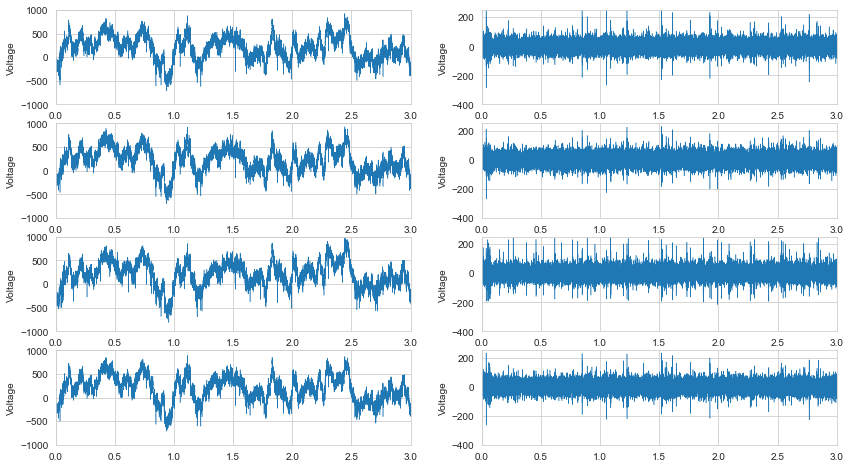

In [5]:
plt.figure(figsize=(14, 8))

T = 100000
t = np.arange(0,T) * dt 
    
for i, col in enumerate(xf):
    plt.subplot(4,2,2*i+1)
    plt.plot(t,x[col][0:T],linewidth=.5)
    plt.ylim((-1000, 1000))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
        
    plt.subplot(4,2,2*i+2)
    plt.plot(t,xf[col][0:T],linewidth=.5)
    plt.ylim((-400, 250))
    plt.xlim((0,3))
    plt.ylabel('Voltage')

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detectSpikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. Plot the threshold.

In [6]:
def get_threshold(data,N):
    mean = np.mean(data)
    sigma = np.median(np.absolute(data-mean)/0.6745)
    threshold = -N * sigma
    
    return threshold

def detectSpikes(x,Fs):
# Detect spikes
# s, t = detectSpikes(x,Fs) detects spikes in x, where Fs the sampling
#   rate (in Hz). The outputs s and t are column vectors of spike times in
#   samples and ms, respectively. By convention the time of the zeroth
#   sample is 0 ms.
    
    N = 6
 
    s = np.zeros(x.shape[0])
    
    for row in x.T:
        threshold = get_threshold(row,N)
        print(threshold)
        s = s + (row < threshold).astype(int)
        print(np.sum(s))
    
    s = (s > 0)
    
        
    #t = s.copy()

    s = s * np.arange(s.shape[0])
    t = (s * 1000)/Fs
    
    s = s[s!=0]
    t = t[t!=0]
    
    print(s.shape)
    print(t.shape)
    
    return (s.T, t.T)    

In [7]:
T = xf.shape[0]
s, t = detectSpikes(xf.to_numpy(),Fs)
thresh = get_threshold(xf.values, 6)

-214.91695587041545
8976.0
-225.51777728684104
10866.0
-230.16015631252077
24129.0
-217.9128400713106
28536.0
(20735,)
(20735,)


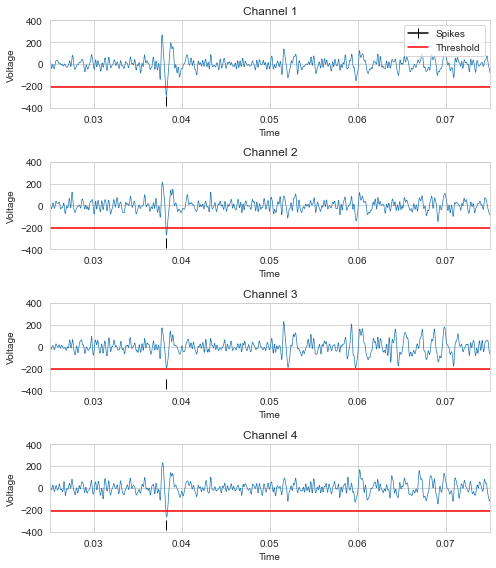

In [8]:
plt.figure(figsize=(7, 8))

tt = np.arange(0,T) * dt 
first = True
for i, col in enumerate(xf):  
    plt.subplot(4,1,i+1)
    plt.plot(tt,xf[col],linewidth=.7)
    plt.plot(0.0382,-340,'black', markersize=10, marker='|', label='Spikes')
    plt.axhline(y=thresh*0.93, color='r', linestyle='-', label='Threshold')
    plt.ylim((-400, 400))
    plt.xlim((0.025,0.075))
    plt.ylabel('Voltage')
    plt.xlabel('Time')
    plt.title(label='Channel ' + str(i+1))
    if first:
        plt.legend(loc='upper right')
        first=False
plt.tight_layout()


## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extractWaveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected.

In [9]:
def extractWaveforms(x, s):
# Extract spike waveforms.
#   w = extractWaveforms(x, s) extracts the waveforms at times s (given in
#   samples) from the filtered signal x using a fixed window around the
#   times of the spikes. The return value w is a 3d array of size
#   length(window) x #spikes x #channels.
    print(s.shape)
    print(x.shape)
    window_size = 30 # 30000 hz * 1 /1000s
    
    w = []
    
    for spike_detection_idx in s:
        minimum = 1000#x[spike_detection_idx] 
        minimum_idx = spike_detection_idx
        
        #search for the minimum in the neighborhood to align spikes at that index
        for window_idx in range(max(-window_size//2 + spike_detection_idx,0) , min(window_size//2 + spike_detection_idx, x.shape[0])):
            
            if np.less(x[window_idx], minimum).any():
                minimum = x[window_idx]
                minimum_idx = window_idx
        
        #write out spike window
        bound_left = max(minimum_idx - window_size//2,0)
        bound_right = min(minimum_idx + window_size//2, x.shape[0])
        wave_window = x[bound_left:bound_right,:]
        w.append(wave_window)
    
    #remove any duplicates that have been detected and aligned at the minimum
    w = np.stack(w, axis=1)
    print(f"number of spikes:{w.shape[1]}")
    w = np.unique(w, axis=1)
    print(f"number of unique spikes:{w.shape[1]}")
    return w 

In [10]:
w = extractWaveforms(xf.values,s)

(20735,)
(19199999, 4)
number of spikes:20735
number of unique spikes:5356


Plot first 100 spike waveforms

(30, 100)
(30, 100)
(30, 100)
(30, 100)


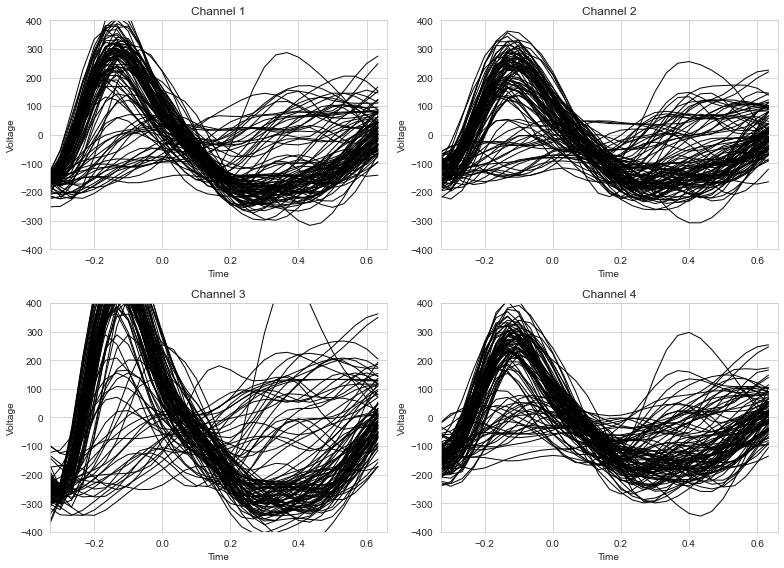

In [11]:
t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    print(w[:,0:100,i].shape)
    plt.plot(t,w[:,0:100,i],'k', linewidth=1)
    plt.ylim((-400, 400))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')
    plt.xlabel('Time')
    plt.title(label='Channel ' + str(i+1))
plt.tight_layout()


Plot largest 100 spike waveforms

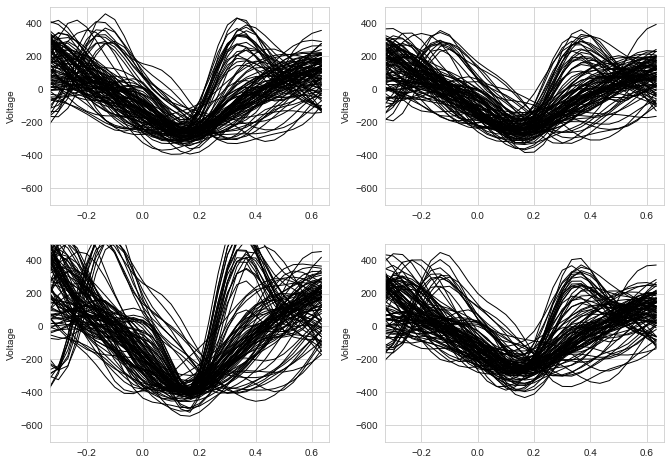

In [12]:
idx = np.argsort(np.min(np.min(w,axis=2),axis=0))


t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,idx[0:100],i],'k', linewidth=1)
    plt.ylim((-700, 500))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')
